In [1]:
import json

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import torch_geometric.utils as utils
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn import GINConv
from sklearn.model_selection import train_test_split
import torch_geometric as tg
import numpy as np
from scipy.sparse import csr_matrix
from scipy import sparse as sp
import numpy as np
import networkx as nx
import sys

In [2]:
def calculatePosEncodings_rswe(edge_index, num_nodes):
    edge_index = edge_index.t().tolist()
    edges = [(src, dst) for src, dst in edge_index]
    rows, cols = zip(*edges)
    data = np.ones(len(rows))
    A = csr_matrix((data, (rows, cols)), shape=(num_nodes, num_nodes))

    in_degrees_dict = {node: 0 for node in range(num_nodes)}
    # Calculate the in-degrees for each node
    for edge in edges:
        _, dst = edge
        in_degrees_dict[dst] += 1

    in_degrees = np.array([in_degrees_dict[i] for i in range(len(in_degrees_dict))], dtype=float)
    in_degrees = in_degrees.clip(1)  # Clip to ensure no division by zero
    in_degrees = np.power(in_degrees, -1)  # Take the element-wise inverse square root

    Dinv = sp.diags(in_degrees, dtype=float)

    RW = A * Dinv  
    M = RW
    
    # das ist wieder ein Hyperparameter; sollte >1 sein weil eins immer 0 ist irgendwie!
    pos_enc_dim = 5

    nb_pos_enc = pos_enc_dim
    PE = [torch.from_numpy(M.diagonal()).float()]
    M_power = M
    for _ in range(nb_pos_enc-1):
        M_power = M_power * M
        PE.append(torch.from_numpy(M_power.diagonal()).float())
    PE = torch.stack(PE,dim=-1)

    #ERGEBNIS
    RESULT_POS_ENCODING = PE 
    return RESULT_POS_ENCODING

def calculatePosEncodings(edge_index, num_nodes):
    print("checkpoint1")
    edge_index = edge_index.t().tolist()
    edges = [(src, dst) for src, dst in edge_index]

    # Create the adjacency matrix in CSR format -> das wird dann für die encodings benutzt!
    rows, cols = zip(*edges)
    data = np.ones(len(rows))
    A = csr_matrix((data, (rows, cols)), shape=(num_nodes, num_nodes))

    ''' this code computes the in_degrees matrix from the edge list. it can later be adapted to compute the in-degrees matrix from the adjacency matrix (however, then, we should
    do some tests with small sample graphs to ensure everytheing is correct
    '''
    in_degrees_dict = {node: 0 for node in range(num_nodes)}
    # Calculate the in-degrees for each node
    for edge in edges:
        print("checkpoint2")
        _, dst = edge
        in_degrees_dict[dst] += 1

    in_degrees = np.array([in_degrees_dict[i] for i in range(len(in_degrees_dict))], dtype=float)
    in_degrees = in_degrees.clip(1)  # Clip to ensure no division by zero
    in_degrees = np.power(in_degrees, -0.5)  # Take the element-wise inverse square root
    print("checkpoint3")
    # Create the sparse diagonal matrix N
    N = sp.diags(in_degrees, dtype=float)

    L = sp.eye(num_nodes) - N * A * N

    #calc eigvals and eigVecs, equivalent to the original code
    EigVal, EigVec = np.linalg.eig(L.toarray())
    idx = EigVal.argsort() # increasing order
    EigVal, EigVec = EigVal[idx], np.real(EigVec[:,idx])

    #pos_enc_dim = hyperparameter!
    pos_enc_dim = 5
    RESULT_POS_ENCODING = torch.from_numpy(EigVec[:,1:pos_enc_dim+1]).float() 
    return RESULT_POS_ENCODING

def calculateLoss(task_loss, batch, num_nodes, positional_encoding):
    #HYPERPARAMETERS
    device = "cpu"
    pos_enc_dim = 1
    alpha_loss: 1e-3
    lambda_loss: 100  # ist auch 100

    #edge_index im korrekten Format definieren
    edge_index = batch.edge_index.t().tolist()
    edge_index = [(src, dst) for src, dst in edge_index]

    # Loss B: Laplacian Eigenvector Loss --------------------------------------------
    n = num_nodes

    # Laplacian 
    rows, cols = zip(*edge_index)
    data = np.ones(len(rows))
    A = csr_matrix((data, (rows, cols)), shape=(num_nodes, num_nodes))

    ''' this code computes the in_degrees matrix from the edge list. it can later be adapted to compute the in-degrees matrix from the adjacency matrix (however, then, we should
    do some tests with small sample graphs to ensure everything is correct'''

    in_degrees_dict = {node: 0 for node in range(num_nodes)}
    # Calculate the in-degrees for each node
    for edge in edge_index:
        _, dst = edge
        in_degrees_dict[dst] += 1

    in_degrees = np.array([in_degrees_dict[i] for i in range(len(in_degrees_dict))], dtype=float)
    in_degrees = in_degrees.clip(1)  # Clip to ensure no division by zero
    in_degrees = np.power(in_degrees, -0.5)  # Take the element-wise inverse square root

    # Create the sparse diagonal matrix N
    N = sp.diags(in_degrees, dtype=float)
    L = sp.eye(num_nodes) - N * A * N

    p = positional_encoding
    pT = torch.transpose(p, 1, 0)
    loss_b_1 = torch.trace(torch.mm(torch.mm(pT, torch.Tensor(L.todense()).to(device)), p))

    '''  TODO: loss_b_2 
    '''

    loss_b = loss_b_1

    #TODO: parameter tunen!
    loss = task_loss + 1e-3* loss_b
    return loss


def precision(predictions, targets, threshold):
    # Apply a threshold to the predictions
    binary_predictions = (predictions >= threshold).astype(int)
    binary_targets = (targets >= threshold).astype(int)

    # Calculate the true positive (TP) and false positive (FP) counts
    TP = np.sum((binary_predictions == 1) & (binary_targets == 1))
    FP = np.sum((binary_predictions == 1) & (binary_targets == 0))

    print("Negative: ")
    print(np.sum(binary_targets == 1))
    print("Positive: ")
    print(np.sum(binary_targets == 0))
    # Calculate precision
    precision_value = TP / (TP + FP)
    return precision_value

def recall(predictions, targets, threshold):
    # Apply a threshold to the predictions
    binary_predictions = (predictions >= threshold).astype(int)
    binary_targets = (targets >= threshold).astype(int)
    # Calculate the true positive (TP) and false negative (FN) counts
    TP = np.sum((binary_predictions == 1) & (binary_targets == 1))
    FN = np.sum((binary_predictions == 0) & (binary_targets == 1))
    # Calculate recall
    recall_value = TP / (TP + FN)
    return recall_value

def precission_recall_at_k (predictions, targets, threshold, k):
    # Combine ratings and predictions into tuples for sorting
    combined = list(zip(targets, predictions))

    # Sort the combined list in descending order of predictions
    combined.sort(key=lambda x: x[1], reverse=True)

    # Extract top k sorted items and calculate precision and recall
    top_k_items = combined[:k]
    true_positives = sum(1 for rating, _ in top_k_items if rating >= threshold)
    false_positives = k - true_positives
    relevant_items = sum(1 for rating in targets if rating >= threshold)
    false_negatives = relevant_items - true_positives

    precision_at_k = true_positives / (true_positives + false_positives)
    recall_at_k = true_positives / (true_positives + false_negatives)
    normalized_recall_at_k = recall_at_k / (k / relevant_items)


    return precision_at_k, recall_at_k, normalized_recall_at_k

In [3]:
# Reading in all the data

business_ids=[]
business_average_stars=[]
business_review_count=[]

try:
    with open('yelp_dataset/yelp_academic_dataset_business.json', 'r', encoding='utf-8') as json_file:
        for line in json_file:
            try:
                data = json.loads(line)
                business_ids.append(data["business_id"])
                business_average_stars.append(data["stars"])
                business_review_count.append(data["review_count"])
            except json.decoder.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
except FileNotFoundError:
    print("File not found.")
print("done business")

review_ids=[]
review_business_ids=[]
review_user_ids=[]
review_stars=[]

try:
    with open('yelp_dataset/yelp_academic_dataset_review.json', 'r', encoding='utf-8') as json_file:
        for i,line in enumerate(json_file):
            try:
                data = json.loads(line)
                review_ids.append(data["review_id"])
                review_business_ids.append(data["business_id"])
                review_user_ids.append(data["user_id"])
                review_stars.append(data["stars"])
            except json.decoder.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
except FileNotFoundError:
    print("File not found.")
print("done reviews")

user_ids=[]

try:
    with open('yelp_dataset/yelp_academic_dataset_user.json', 'r', encoding='utf-8') as json_file:
        for line in json_file:
            try:
                data = json.loads(line)
                user_ids.append(data["user_id"])
            except json.decoder.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
except FileNotFoundError:
    print("File not found.")
print("done users")

done business
done reviews
done users


In [4]:
# As there is too much data use a subset by manipulating the business and user sets

print(len(user_ids))
print(len(business_ids))
print(len(review_stars))

businesses = 10000
users = 20000

business_average_stars = business_average_stars[:businesses]
business_review_count = business_review_count[:businesses]
business_ids = business_ids[:businesses]

user_ids = user_ids[:users]

print("---------------------------------------------")
print(len(user_ids))
print(len(business_ids))
print(len(review_stars))

1987897
150346
6990280
---------------------------------------------
20000
10000
6990280


In [5]:
# User and business to index mapping in order.
# Review lists are adjusted to only include users and businesses from the subset lists.

user_to_index = {user_id: index for index, user_id in enumerate(set(user_ids))}
business_to_index = {business_id: index for index, business_id in enumerate(set(business_ids))}


user_index_col = [user_to_index[user_id] for user_id in user_ids]
business_index_col = [business_to_index[business_id] for business_id in business_ids]

skip_indexes = []
current_index = -1

for user_id in review_user_ids:
    try:
        current_index = current_index + 1
        tmp = user_to_index[user_id]
    except KeyError:
        skip_indexes.append(current_index)

current_index = -1
for business_id in review_business_ids:
    try:
        current_index = current_index + 1
        tmp = business_to_index[business_id]
    except KeyError:
        skip_indexes.append(current_index)    

skip_indexes = set(skip_indexes)
print(6990280 - len(skip_indexes))

47703


In [6]:
current_index = -1

review_user_index_col = []
for user_id in review_user_ids:
    try:
        current_index = current_index + 1
        if current_index in skip_indexes:
            pass
        else:
            user_index = user_to_index[user_id]
            review_user_index_col.append(businesses+user_index)
    except KeyError:
        print("Huh?")        
        
current_index = -1        
review_business_index_col = []
for business_id in review_business_ids:
    try:
        current_index = current_index + 1
        if current_index in skip_indexes:
            pass
        else:
            business_index = business_to_index[business_id]
            review_business_index_col.append(business_index)
    except KeyError:
        print("Huh?")
    
current_index = -1
adjusted_review_stars = []
for star in review_stars:
        current_index = current_index + 1
        if current_index in skip_indexes:
            pass
        else:
            adjusted_review_stars.append(star)

num_nodes = len(set(review_user_index_col)) + len(set(review_business_index_col)) 
print(num_nodes)
print(len(user_to_index)+len(business_to_index))



print("Number of Users in index col " + str(len(set(review_user_index_col))))
print("Number of businesses in index col " + str(len(set(review_business_index_col))))
print("Total reviews left " + str(len(adjusted_review_stars)))
print(num_nodes)

22403
30000
Number of Users in index col 16327
Number of businesses in index col 6076
Total reviews left 47703
22403


In [7]:
# Feature list including average stars and the review_count/max_review_count of a business.
# Also a dummy padding is added for the users.

adjusted_features = []

for starts in business_average_stars:
    adjusted_features.append([starts])
    
highest_review_count = 0
for review in business_review_count:
    if(review > highest_review_count):
        highest_review_count = review
print(highest_review_count)
        
for i in range(len(business_review_count)):
    adjusted_features[i].append(business_review_count[i]/highest_review_count)

adjusted_features_tensor = torch.tensor(adjusted_features)

num_features = len(adjusted_features[0])

num_users = len(set(user_ids))
user_genre_features = torch.zeros(num_users,num_features)

features = torch.cat((adjusted_features_tensor, user_genre_features), dim=0)

print(features)

4554
tensor([[5.0000e+00, 1.5371e-03],
        [3.0000e+00, 3.2938e-03],
        [3.5000e+00, 4.8309e-03],
        ...,
        [0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00]])


In [8]:
adjusted_review_stars_ud = adjusted_review_stars + adjusted_review_stars
review_user_index_col_ud = review_user_index_col + review_business_index_col
review_business_index_col_ud = review_business_index_col + review_user_index_col

rating_tensor = torch.tensor(adjusted_review_stars_ud, dtype=torch.float)

edge_index = torch.tensor([review_user_index_col_ud, review_business_index_col_ud], dtype=torch.long)

positional_encodings = calculatePosEncodings_rswe(edge_index, 30000)

#TODO: num nodes 30.000 oder num_nodes?
data = Data(edge_index=edge_index, x=features, y=rating_tensor, positional_encodings=positional_encodings)

print(edge_index)

tensor([[11512, 20461, 14585,  ...,  8439,  8453,  5276],
        [ 7949,  6242,  9511,  ..., 19175, 13934, 13383]])


In [9]:

class GCN_nopos(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(7, hidden_channels)
        self.conv1_nopos = GCNConv(2, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv2_var2 = GCNConv(hidden_channels*2, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        #hidden channels funktioniert besser!
        self.conv3_nopos = GCNConv(hidden_channels, hidden_channels)


        #this is for learning of the positional encodings, which is seperate!!!
        self.conv1_pos = GCNConv(5, hidden_channels)
        self.conv2_pos = GCNConv(hidden_channels, hidden_channels)
        self.conv3_pos = GCNConv(hidden_channels, hidden_channels)

        self.linear = nn.Linear(hidden_channels, 1)
        
    def forward(self, x, edge_index, pos_embeddings):
        x = x.view(-1, x.size(2))
        #fh from the paper
        x = self.conv1_nopos(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3_nopos(x, edge_index)

        movie_embed = x[edge_index[1]]
        
        ratings = torch.sum(movie_embed, dim=1)

        return ratings


class GCN_var1(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # number of in layers = number of node features + number of positional embedding dimensions
        # TODO: ADAPT WHEN ADDING FEATURES OR EMBEDDING DIMENSIONS!!!!
        self.conv1 = GCNConv(7, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

        #this is for learning of the positional encodings, which is seperate!!!
        self.conv1_pos = GCNConv(5, hidden_channels)
        self.conv2_pos = GCNConv(hidden_channels, hidden_channels)
        self.conv3_pos = GCNConv(hidden_channels, hidden_channels)

        self.linear = nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, pos_embeddings):
        x = x.view(-1, x.size(2))
        pos_embeddings = pos_embeddings.view(-1, pos_embeddings.size(2))
        x = torch.cat([x, pos_embeddings], dim=1)

        #fh from the paper
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)

        #Now the learning of positional embeddings. So this is fp from the paper
        pos_embeddings = self.conv1_pos(pos_embeddings, edge_index)
        pos_embeddings = F.relu(pos_embeddings)
        pos_embeddings = self.conv2_pos(pos_embeddings, edge_index)
        pos_embeddings = F.relu(pos_embeddings)
        pos_embeddings = self.conv3_pos(pos_embeddings, edge_index)

        final_output = self.linear(torch.cat([x, pos_embeddings]))

        movie_embed = final_output[edge_index[1]]            
        ratings = torch.sum(movie_embed, dim=1)
        return ratings


class GCN_variant2(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # number of in layers = number of node features + number of positional embedding dimensions
        # TODO: ADAPT WHEN ADDING FEATURES OR EMBEDDING DIMENSIONS!!!!
        self.conv1 = GCNConv(7, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv2_var2 = GCNConv(hidden_channels*2, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

        #this is for learning of the positional encodings, which is seperate!!!
        self.conv1_pos = GCNConv(5, hidden_channels)
        self.conv2_pos = GCNConv(hidden_channels, hidden_channels)
        self.conv3_pos = GCNConv(hidden_channels, hidden_channels)

        self.linear = nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, pos_embeddings):
        x = x.view(-1, x.size(2))
        pos_embeddings = pos_embeddings.view(-1, pos_embeddings.size(2))
        x = torch.cat([x, pos_embeddings], dim=1)

        #fh from the paper
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        pos_embeddings = self.conv1_pos(pos_embeddings, edge_index)
        pos_embeddings = F.relu(pos_embeddings)
        #x = self.conv2(torch.cat([x,pos_embeddings],dim=1), edge_index)
        x = self.conv2_var2(torch.cat([x,pos_embeddings],dim=1), edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)

        movie_embed = x[edge_index[1]]
        ratings = torch.sum(movie_embed, dim=1)

        return ratings


C:\Users\andre\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/300, Training Loss: 25.68608283996582, Validation Loss: 21.37664031982422
Epoch 2/300, Training Loss: 20.579904556274414, Validation Loss: 16.96460723876953
Epoch 3/300, Training Loss: 16.301538467407227, Validation Loss: 13.262295722961426
Epoch 4/300, Training Loss: 12.801722526550293, Validation Loss: 10.28968620300293
Epoch 5/300, Training Loss: 10.028038024902344, Validation Loss: 8.106943130493164
Epoch 6/300, Training Loss: 7.980322360992432, Validation Loss: 6.6806159019470215
Epoch 7/300, Training Loss: 6.663872241973877, Validation Loss: 5.591006278991699
Epoch 8/300, Training Loss: 5.590228080749512, Validation Loss: 4.699077606201172
Epoch 9/300, Training Loss: 4.742715835571289, Validation Loss: 4.206088066101074
Epoch 10/300, Training Loss: 4.331237316131592, Validation Loss: 4.193005561828613
Epoch 11/300, Training Loss: 4.408010005950928, Validation Loss: 4.478495121002197
Epoch 12/300, Training Loss: 4.774759769439697, Validation Loss: 4.751919746398926
Epoch 1

Epoch 101/300, Training Loss: 1.3644566535949707, Validation Loss: 1.3502192497253418
Epoch 102/300, Training Loss: 1.3600504398345947, Validation Loss: 1.346165657043457
Epoch 103/300, Training Loss: 1.3558392524719238, Validation Loss: 1.3422868251800537
Epoch 104/300, Training Loss: 1.3518155813217163, Validation Loss: 1.338578701019287
Epoch 105/300, Training Loss: 1.3479726314544678, Validation Loss: 1.3350372314453125
Epoch 106/300, Training Loss: 1.3443025350570679, Validation Loss: 1.3316576480865479
Epoch 107/300, Training Loss: 1.3407979011535645, Validation Loss: 1.3284345865249634
Epoch 108/300, Training Loss: 1.3374518156051636, Validation Loss: 1.3253626823425293
Epoch 109/300, Training Loss: 1.334256887435913, Validation Loss: 1.3224363327026367
Epoch 110/300, Training Loss: 1.3312063217163086, Validation Loss: 1.3196496963500977
Epoch 111/300, Training Loss: 1.3282933235168457, Validation Loss: 1.316996693611145
Epoch 112/300, Training Loss: 1.3255119323730469, Validati

Epoch 199/300, Training Loss: 1.2703224420547485, Validation Loss: 1.2639116048812866
Epoch 200/300, Training Loss: 1.2702950239181519, Validation Loss: 1.2638802528381348
Epoch 201/300, Training Loss: 1.2702692747116089, Validation Loss: 1.2638509273529053
Epoch 202/300, Training Loss: 1.2702451944351196, Validation Loss: 1.2638227939605713
Epoch 203/300, Training Loss: 1.270222544670105, Validation Loss: 1.263796091079712
Epoch 204/300, Training Loss: 1.2702009677886963, Validation Loss: 1.2637698650360107
Epoch 205/300, Training Loss: 1.2701809406280518, Validation Loss: 1.2637447118759155
Epoch 206/300, Training Loss: 1.2701621055603027, Validation Loss: 1.2637206315994263
Epoch 207/300, Training Loss: 1.2701443433761597, Validation Loss: 1.263697624206543
Epoch 208/300, Training Loss: 1.270127773284912, Validation Loss: 1.2636752128601074
Epoch 209/300, Training Loss: 1.2701125144958496, Validation Loss: 1.263654112815857
Epoch 210/300, Training Loss: 1.2700986862182617, Validatio

C:\Users\andre\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/300, Training Loss: 15.01095962524414, Validation Loss: 14.424958229064941
Epoch 2/300, Training Loss: 14.337753295898438, Validation Loss: 13.86246109008789
Epoch 3/300, Training Loss: 13.811692237854004, Validation Loss: 13.383710861206055
Epoch 4/300, Training Loss: 13.360231399536133, Validation Loss: 12.906123161315918
Epoch 5/300, Training Loss: 12.902227401733398, Validation Loss: 12.400491714477539
Epoch 6/300, Training Loss: 12.407590866088867, Validation Loss: 11.854714393615723
Epoch 7/300, Training Loss: 11.86825180053711, Validation Loss: 11.266538619995117
Epoch 8/300, Training Loss: 11.282959938049316, Validation Loss: 10.63065242767334
Epoch 9/300, Training Loss: 10.649086952209473, Validation Loss: 9.940839767456055
Epoch 10/300, Training Loss: 9.964900970458984, Validation Loss: 9.2007474899292
Epoch 11/300, Training Loss: 9.23444938659668, Validation Loss: 8.42455768585205
Epoch 12/300, Training Loss: 8.469527244567871, Validation Loss: 7.627989768981934
Epoc

KeyboardInterrupt: 

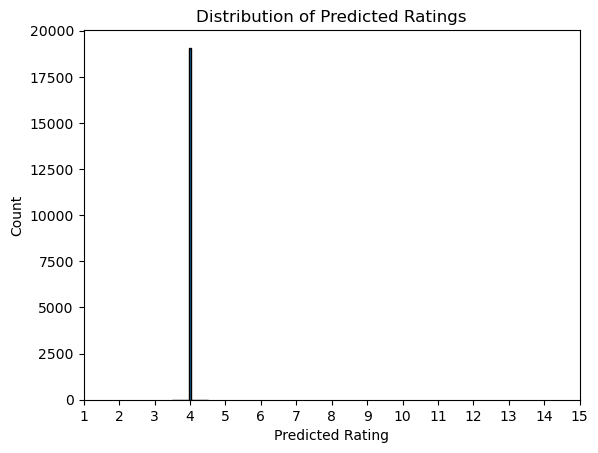

In [10]:
indices = list(range(data.edge_index.size(1)))
import csv
csv_filename = "results.csv"
with open(csv_filename, mode='a', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["i", "Model", "Precision", "Recall", "Precision@k", "Recall@k", "MSE"])  # Write header




for i in range(30):
    #das hier klein, damit der Speicher nicht überdreht wird. Aber nicht zu klein, weil sonst kommt es zu problemen!
    if (i % 3 == 0):
        train_indices, test_indices = train_test_split(indices, train_size=0.8, test_size=0.2)
        train_indices, val_indices = train_test_split(train_indices, train_size=0.8, test_size=0.2, random_state=42)
        np.savez('indices.npz', train_indices=train_indices, test_indices=test_indices, val_indices=val_indices)
    # Now, you can comment out the above code that generates the indices
    # Read the indices from the file
    loaded_indices = np.load('indices.npz')
    #irgendeine syntax
    train_data = data.__class__()
    test_data = data.__class__()
    val_data = data.__class__()


    #setzt die Parameter von train_data und test_data

    #soweit ich es verstehe, sind alle 2.500 nodes im training und testset vorhanden. gesplittet werden nur die edges, d.h. 
    #es ist nur ein subset der 100.000 edges im training set sowie im test set vorhanden
    # also 10% der Bewertungen 
    train_data.edge_index = data.edge_index[:, train_indices]
    train_data.y = data.y[train_indices]
    train_data.num_nodes = data.num_nodes
    train_data.positional_encodings = data.positional_encodings
    train_data.x = data.x


    test_data.edge_index = data.edge_index[:, test_indices]
    test_data.y = data.y[test_indices]
    test_data.num_nodes = data.num_nodes
    test_data.positional_encodings = data.positional_encodings
    test_data.x = data.x


    val_data.edge_index = data.edge_index[:, val_indices]
    val_data.y = data.y[val_indices]
    val_data.num_nodes = data.num_nodes
    val_data.positional_encodings = data.positional_encodings
    val_data.x = data.x
        


    # Step 6: Train and evaluate the GCN model
    # Set seed for reproducibility
    torch.manual_seed(42)

    # Set the device --> aktiviere GPU falls vorhanden
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #------------------------------------------------------

    #hidden channels und epochs tunen
    hidden_channels=8 #8 und 16
    lr = 0.01  #0.01 vs 0.001 
    epochs = 300  #100 vs 200
    batch_size = 512#512

    #1, 16, 32 ,64, 128, 256, 512

    #Early Stopping
    patience = 40  # Number of epochs to wait for improvement
    min_delta = 0.001  # Minimum improvement required to consider as improvement

    best_val_loss = np.inf
    best_epoch = 0
    early_stop_counter = 0

    # this is for evaluation!
    if (i % 3 == 0):
        model = GCN_nopos(hidden_channels=hidden_channels)
    elif (i % 3 == 1):
        model = GCN_var1(hidden_channels=hidden_channels)
    elif (i%3 == 2):
        model = GCN_variant2(hidden_channels=hidden_channels)
    #------------------------------------------------------
    #loss function, and optimizer, MSE = Metrik für Loss 
    criterion = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Create data loaders for training and test sets
    train_loader = DataLoader([train_data], batch_size=batch_size)
    test_loader = DataLoader([test_data], batch_size=batch_size)
    val_loader = DataLoader([val_data], batch_size=batch_size)

    # Model training
    model.train()

    train_losses = []
    val_losses = []
    predictions =[]

    import matplotlib.pyplot as plt

    for epoch in range(epochs):
        # Training
        train_loss = 0.0
        
        for batch in train_loader:
            batch = batch.to(device)
            out = model( batch.x.unsqueeze(1), batch.edge_index, batch.positional_encodings.unsqueeze(1))
            task_loss = criterion(out, batch.y)
            loss = task_loss
            #loss = calculateLoss(task_loss, batch, num_nodes, batch.positional_encodings)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch.num_graphs
            predictions = out.detach().cpu().numpy()
            #print(predictions)

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

    # Validation
        model.eval()
        val_loss = 0.0
        for batch in val_loader:
            batch = batch.to(device)
            out= model(batch.x.unsqueeze(1),batch.edge_index, batch.positional_encodings.unsqueeze(1))
            task_loss = criterion(out, batch.y)
            loss = task_loss
        # loss = calculateLoss(task_loss, batch, num_nodes, batch.positional_encodings)
            
            val_loss += loss.item() * batch.num_graphs

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Print training and validation loss for monitoring
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}")

        # Check for early stopping
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_epoch = epoch
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Set the model back to training mode
        model.train()
        '''
        # Plotting training and validation curves
        plt.plot(train_losses, label='Training Loss')
        #plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Save the plot as an image file
        plt.savefig('loss_plot.png')
        '''

        # Show the plot

    # Evaluation on test set
    model.eval()
    with torch.no_grad():
        predictions = []
        targets = []

        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch.x.unsqueeze(1), batch.edge_index, batch.positional_encodings.unsqueeze(1))
            task_loss = criterion(out, batch.y)
            test_loss = task_loss
            #test_loss = calculateLoss(task_loss, batch, num_nodes, batch.positional_encodings)
            
            #print(f'Test Loss: {test_loss.item()}')
            predictions.extend(out.cpu().numpy().flatten())
            targets.extend(batch.y.cpu().numpy().flatten())

        predictions = np.array(predictions)
        targets = np.array(targets)

        rounded_predictions = np.round(predictions, decimals=0)  # Round the predicted ratings

        # Plotting the distribution
        plt.hist(rounded_predictions, bins=15, edgecolor='black')
        plt.xlabel('Predicted Rating')
        plt.ylabel('Count')
        plt.title('Distribution of Predicted Ratings')
        plt.xticks(range(1, 16))
        #plt.show()
        plt.savefig('predicted_rankings.png')


        mse = np.mean(np.abs(predictions - targets) ** 2)
        rmse = np.sqrt(mse)
        k = 5  # Define the value of k

        print(f"Batch Size: {batch_size}")
        print(f"Epochs: {epochs}")
        print   (f"MSE: {mse}")
        print(f"RMSE: {rmse}")
        
        threshold = 3.5 # Define the threshold to convert predictions into binary values
        np.set_printoptions(threshold=sys.maxsize)  # Set the threshold to print the whole array

        #print(rounded_predictions)
        #print(predictions)

        GAT_results = open("predictions_GAT.txt", "a")

        GAT_results.write(str(predictions))
        
        GAT_results.close()

        precision_value = precision(predictions, targets, threshold)
        recall_value = recall(predictions, targets, threshold)
        precission_k, recall_k, normalized_recall_k = precission_recall_at_k(predictions, targets, 4, 1000)

        with open("predictions.txt", 'w') as file:
            for prediction in predictions:
                file.write(str(prediction) + '\n')

        print(f"Precision: {precision_value}")
        print(f"Recall: {recall_value}")

        
        print(f"Precision@k: {precission_k}")
        print(f"Recall@k: {recall_k}")
        #print(f"Normalized Recall@k: {normalized_recall_k}")

        #Now write the file! 
        if (i % 3 == 0):
            model_name = "GCN_nopos"
        elif (i % 3 == 1):
            model_name = "GCN_var1"
        elif (i%3 == 2):
            model_name = "GCN_variant2"
        
        print(i)
        with open("results.csv", mode='a', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)
            csv_writer.writerow([i, model_name, precision_value, recall_value, precission_k, recall_k, mse])


  

